In [4]:
import sys
import csv
import json
import requests
import requests_cache
import numpy as np
import pandas as pd
#from yahoo_finance import Share
from pprint import pprint 
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

import missingno as msno

In [5]:
requests_cache.install_cache('cache')

In [6]:
# Yahoo! YQL API
PUBLIC_API_URL = 'https://query.yahooapis.com/v1/public/yql'
OAUTH_API_URL = 'https://query.yahooapis.com/v1/yql'
DATATABLES_URL = 'store://datatables.org/alltableswithkeys'

def myreq(ticker, start, end):
    '''
    input ticker & dates as strings form 'YYYY-MM-DD'
    '''
    params = {'format':'json',
             'env':DATATABLES_URL}
    query = 'select * from yahoo.finance.historicaldata where symbol = "{}" and startDate = "{}" and endDate = "{}"'.format(ticker,start, end)
    params.update({'q':query})
    req = requests.get(PUBLIC_API_URL, params=params)
    req.raise_for_status()
    req = req.json()
    if req['query']['count'] > 0:
        result = req['query']['results']['quote']
        return result
    else:
        pass

In [7]:
#NEW price function
def price2(ticker):
    date=[]
    price=[]
    report = []
    
    years = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
    for x in range(len(years)):
        c = myreq(ticker,'{}-01-01'.format(years[x]),'{}-12-31'.format(years[x]))
        try:
        
            for i in range(0,len(c)):
                date.append(pd.to_datetime(c[i]["Date"]))
                price.append(float(c[i][u'Close']))
                datef = pd.DataFrame(date)
                pricef = pd.DataFrame(price)
                table1 = pd.concat([datef,pricef],axis = 1)
                table1.columns = ['Date', ticker]
                table1 = table1.set_index("Date")
            
        except Exception:
            table1 = pd.DataFrame()
    
    return table1

In [8]:
csv = pd.read_csv('./companylist.csv')
# We want to keep "Finance, Health Care, Technology, Energy"
newcsv = csv[csv["Sector"].isin(["Finance", "Energy","Health Care","Technology"])].reset_index()
del newcsv["index"]

In [9]:
whole_list = newcsv['Symbol']
whole_list

0         PIH
1        FCCY
2        SRCE
3        VNET
4        TWOU
5        JOBS
6        ABEO
7       ABEOW
8        ABIL
9        ABMD
10       AXAS
11       ACIU
12       ACIA
13       ACHC
14       ACAD
15       ACST
16       XLRN
17       ANCX
18       ARAY
19       ACRX
20       ACET
21       AKAO
22       ACHN
23       ACIW
24       ACRS
25       ACNB
26       ACOR
27       ATVI
28       ACTA
29       ACXM
        ...  
1744     WVFC
1745     XBIT
1746     XNCR
1747     XBIO
1748     XBKS
1749     XENE
1750     XLNX
1751     XOMA
1752     XPLR
1753     XTLB
1754     XNET
1755     YHOO
1756     YNDX
1757      YIN
1758       YY
1759     ZFGN
1760     ZAIS
1761     ZBRA
1762     ZLTQ
1763       ZN
1764    ZNWAA
1765     ZION
1766    ZIONW
1767    ZIONZ
1768     ZIOP
1769     ZIXI
1770     ZGNX
1771     ZSAN
1772     ZYNE
1773     ZNGA
Name: Symbol, dtype: object

In [12]:
#del df
for l in whole_list:
    get = price2(l)
    try:
        df = pd.concat([df,get],axis = 1)    # concat. by column 
    except NameError:
        df = pd.DataFrame(get)    # initialize automatically
    print l

PIH
FCCY
SRCE
VNET
TWOU
JOBS
ABEO
ABEOW
ABIL
ABMD
AXAS
ACIU
ACIA
ACHC
ACAD
ACST
XLRN
ANCX
ARAY
ACRX
ACET
AKAO
ACHN
ACIW
ACRS
ACNB
ACOR
ATVI
ACTA
ACXM
ADMS
ADMP
ADAP
ADUS
IOTS
ADMA
ADBE
ADRO
AAAP
AMD
ADXS
ADXSW
ADVM
AGLE
AERI
AEZS
GNMX
AFMD
AGEN
AGRX
AGYS
AGIO
AGFS
AGFSW
AIMT
AIRG
AMCN
AKTX
AKBA
AKER
AKRX
ALRM
AMRI
ALBO
ADHD
ALDR
ALDX
ALXN
ALGN
ALIM
ALKS
ABTX
AIQ
AHGP
ARLP
AHPI
ALQA
ALLT
MDRX
AFAM
ALNY
AOSL
GOOG
GOOGL
ATEC
AMAG
AMRN
AYA
AMBC
AMBCW
AMBA
DOX
AMDA
AMED
ATAX
AETI
AMNB
ANAT
AMRB
AMSWA
ABCB
AMSF
ASRV
ASRVP
ATLO
AMGN
FOLD
AMKR
AMPH
ASYS
AFSI
ADI
ANAB
AVXL
ANCB
ANDA
ANDAR
ANDAU
ANDAW
ANGO
ANIP
ANIK
ANSS
ATRS
ANTH
APEN
APPF
AAPL
AGTC
AMAT
AAOI
AREX
APTI
APRI
APVO
APTO
AQXP
ARDM
ARLZ
PETX
ABUS
ABIO
ACGL
ACGLP
ARDX
ARNA
AGII
AGIIL
ARGS
ARIS
ARQL
ARRY
ARRS
AROW
ARWR
ASBB
ASND
ASML
AZPN
ASMB
ASFI
ALOT
ASUR
ATRA
ATHX
AAME
ACBI
ACFC
ATLC
AFH
TEAM
ATOM
ATOS
ATRC
ATRI
ATTU
LIFE
AUBN
BOLD
AUPH
EARS
ABTL
ADSK
ADP
AVDL
AVEO
AVXS
AVNW
AVID
AVGR
AVIR
AHPA
AHPAU
AHPAW
AWRE
AXAR
AXARU
AXARW
AC

In [13]:
df

,PIH,FCCY,SRCE,VNET,TWOU,JOBS,ABEO,ABIL,ABMD,AXAS,...,ZLTQ,ZN,ZION,ZIONW,ZIOP,ZIXI,ZGNX,ZSAN,ZYNE,ZNGA
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,21.499973,25.830002,NaN,NaN,14.950000,0.51,NaN,9.350000,5.55,...,NaN,NaN,76.480003,NaN,3.60,1.93,NaN,NaN,NaN,NaN
2006-01-04,NaN,21.499973,25.659998,NaN,NaN,14.790000,0.47,NaN,9.620000,5.55,...,NaN,NaN,77.019997,NaN,4.00,2.04,NaN,NaN,NaN,NaN
2006-01-05,NaN,20.999980,25.820004,NaN,NaN,16.150000,0.46,NaN,9.550000,5.81,...,NaN,NaN,77.720001,NaN,4.00,2.20,NaN,NaN,NaN,NaN
2006-01-06,NaN,20.519969,25.950002,NaN,NaN,17.080000,0.45,NaN,9.750000,5.95,...,NaN,NaN,78.529999,NaN,4.25,2.09,NaN,NaN,NaN,NaN
2006-01-09,NaN,20.249976,25.999997,NaN,NaN,17.900000,0.43,NaN,10.150000,5.55,...,NaN,NaN,77.879997,NaN,4.25,2.02,NaN,NaN,NaN,NaN
2006-01-10,NaN,19.999980,25.999997,NaN,NaN,17.860001,0.46,NaN,10.210000,5.69,...,NaN,NaN,76.970001,NaN,4.25,2.05,NaN,NaN,NaN,NaN
2006-01-11,NaN,20.369968,25.999997,NaN,NaN,17.950001,0.50,NaN,10.550000,5.50,...,NaN,NaN,77.419998,NaN,4.25,2.07,NaN,NaN,NaN,NaN
2006-01-12,NaN,20.000001,25.940002,NaN,NaN,17.480000,0.48,NaN,10.710000,5.46,...,NaN,NaN,76.250000,NaN,4.25,1.95,NaN,NaN,NaN,NaN


In [11]:
test = df

In [14]:
# SAVE THE RESULT LOCALLY:
df.to_pickle('mydf')

# load it back using:
#df = pd.read_pickle('cached_df_presentation.pkl')

In [15]:
pickletest = pd.read_pickle('mydf')

In [16]:
pickletest

,PIH,FCCY,SRCE,VNET,TWOU,JOBS,ABEO,ABIL,ABMD,AXAS,...,ZLTQ,ZN,ZION,ZIONW,ZIOP,ZIXI,ZGNX,ZSAN,ZYNE,ZNGA
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,21.499973,25.830002,NaN,NaN,14.950000,0.51,NaN,9.350000,5.55,...,NaN,NaN,76.480003,NaN,3.60,1.93,NaN,NaN,NaN,NaN
2006-01-04,NaN,21.499973,25.659998,NaN,NaN,14.790000,0.47,NaN,9.620000,5.55,...,NaN,NaN,77.019997,NaN,4.00,2.04,NaN,NaN,NaN,NaN
2006-01-05,NaN,20.999980,25.820004,NaN,NaN,16.150000,0.46,NaN,9.550000,5.81,...,NaN,NaN,77.720001,NaN,4.00,2.20,NaN,NaN,NaN,NaN
2006-01-06,NaN,20.519969,25.950002,NaN,NaN,17.080000,0.45,NaN,9.750000,5.95,...,NaN,NaN,78.529999,NaN,4.25,2.09,NaN,NaN,NaN,NaN
2006-01-09,NaN,20.249976,25.999997,NaN,NaN,17.900000,0.43,NaN,10.150000,5.55,...,NaN,NaN,77.879997,NaN,4.25,2.02,NaN,NaN,NaN,NaN
2006-01-10,NaN,19.999980,25.999997,NaN,NaN,17.860001,0.46,NaN,10.210000,5.69,...,NaN,NaN,76.970001,NaN,4.25,2.05,NaN,NaN,NaN,NaN
2006-01-11,NaN,20.369968,25.999997,NaN,NaN,17.950001,0.50,NaN,10.550000,5.50,...,NaN,NaN,77.419998,NaN,4.25,2.07,NaN,NaN,NaN,NaN
2006-01-12,NaN,20.000001,25.940002,NaN,NaN,17.480000,0.48,NaN,10.710000,5.46,...,NaN,NaN,76.250000,NaN,4.25,1.95,NaN,NaN,NaN,NaN


In [12]:
# df = pd.read_pickle('cached_df_presentation.pkl')

In [13]:
"""
# For the purposes of labeling/analysis, TRANSPOSE() the data frame.
df_long = df.transpose()
# Create a temporary'Symbol' column (necessary later for merging Sector types)
df_long['Symbol'] = df_long.index
"""

In [34]:
final = newcsv.reset_index()
df_long = df.transpose()
sector  = final[['Symbol','Sector']]
sector = sector.set_index('Symbol')

In [51]:
final = df_long.join(sector)

In [53]:
final.head()

,2006-01-03 00:00:00,2006-01-04 00:00:00,2006-01-05 00:00:00,2006-01-06 00:00:00,2006-01-09 00:00:00,2006-01-10 00:00:00,2006-01-11 00:00:00,2006-01-12 00:00:00,2006-01-13 00:00:00,2006-01-17 00:00:00,...,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00,Sector
PIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.700000,7.601000,7.583000,7.400000,7.650000,7.400000,7.400000,7.250000,7.800000,Finance
FCCY,21.499973,21.499973,20.999980,20.519969,20.249976,19.999980,20.369968,20.000001,20.779999,20.160010,...,17.250000,17.549999,17.350000,17.280001,17.350000,18.100000,18.250000,18.000000,18.700001,Finance
SRCE,25.830002,25.659998,25.820004,25.950002,25.999997,25.999997,25.999997,25.940002,25.989997,25.910006,...,44.189999,45.000000,44.439999,44.400002,44.200001,44.740002,44.700001,45.330002,44.660000,Finance
VNET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320000,7.320000,7.100000,6.990000,7.050000,7.150000,7.090000,6.960000,7.010000,Technology
TWOU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.669998,33.049999,32.099998,30.740000,30.809999,30.549999,30.340000,29.770000,30.150000,Technology


In [55]:
# take average within groups for each recorded date:
avg_sector = final.groupby('Sector').mean().reset_index('Sector')
avg_sector = avg_sector.set_index('Sector')
avg_sector

,2006-01-03 00:00:00,2006-01-04 00:00:00,2006-01-05 00:00:00,2006-01-06 00:00:00,2006-01-09 00:00:00,2006-01-10 00:00:00,2006-01-11 00:00:00,2006-01-12 00:00:00,2006-01-13 00:00:00,2006-01-17 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
Sector,,,,,,,,,,,,,,,,,,,,,
Energy,5.550000,5.55000,5.810000,5.95000,5.550000,5.690000,5.500000,5.460000,5.420000,6.180000,...,2.520000,2.550000,2.570000,2.630000,2.620000,2.610,2.65,2.640000,2.640000,2.570000
Finance,20.756658,20.58999,20.446661,19.97999,19.183324,19.083326,18.923322,18.836668,19.106665,18.773339,...,19.898001,20.028000,20.224200,20.108600,20.018001,20.074,20.31,20.290000,20.268001,20.338000
Health Care,5.475000,5.53000,5.530000,5.71000,5.867500,5.985000,6.032500,6.052500,5.920000,5.817500,...,26.243333,25.985555,25.681111,25.362222,25.127778,25.660,25.66,25.233333,25.314445,25.157778
Technology,14.950000,14.79000,16.150000,17.08000,17.900000,17.860001,17.950001,17.480000,17.809999,18.309999,...,34.682499,34.769999,34.924999,34.492499,34.122501,34.180,34.58,34.245001,33.397500,33.177500


In [64]:
# Dates as index for plotting
# This is basically the original DF (transposed and transposed back)
# but the columns are now the Sector averages.
avg_T = avg_sector.transpose()

## Volatility Analysis

In [57]:
# A new DF for the difference between each day:
delta_df = pd.DataFrame()
for sect in avg_T.columns:
    delta_df[sect] = (avg_T[sect] - avg_T[sect].shift(1))/avg_T[sect].shift(1) 
delta_df.columns = map(lambda name: '{} Changes'.format(name),avg_T.columns)

# On what day did the stock price spike the most?
abs(delta_df).idxmax()

Energy Changes        2009-01-06
Finance Changes       2008-10-10
Health Care Changes   2007-02-08
Technology Changes    2011-04-21
dtype: datetime64[ns]

In [72]:
shade = delta_df['Energy Changes']

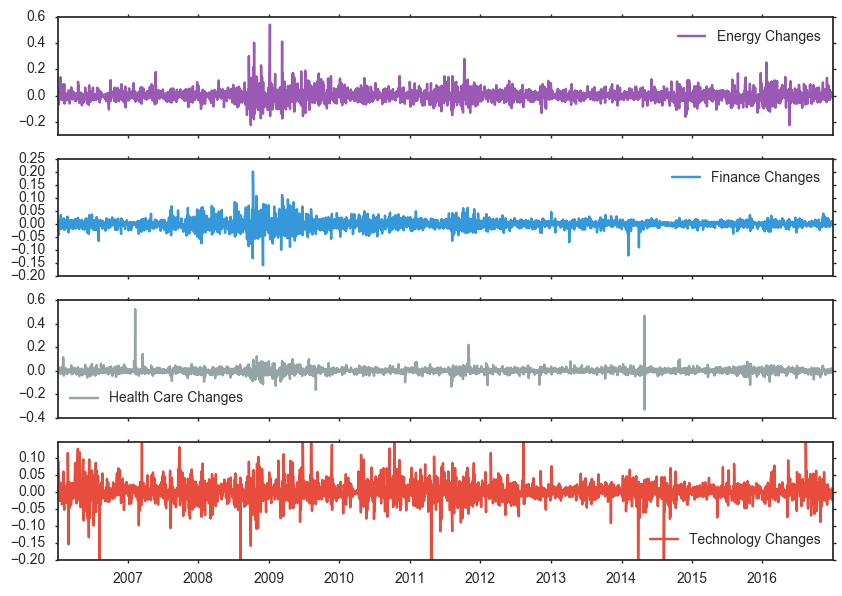

In [62]:
plot_cols = list(delta_df)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
delta_df[plot_cols].plot(subplots=True, ax=axes)
plt.ylim([-0.20,0.150])
plt.show()

#### Mega-function with everything related to the NYT API inside (work in progress)

In [23]:
from nytimesarticle import articleAPI
import time
api = articleAPI('2679a66fe8df4740b754f98e52ad068c')
def news_articles(sector,pages):
    sector_df = pd.DataFrame()
    for i in range(pages):
        try:
            if sector == 'Health Care':
                sector_articles = api.search( 
                    q = 'Health Care',
                    fq = {
                        'subject.contains':['Health', 'Care','Insurance','Drug'],
                        'type_of_material':'News'},
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                    )
            if sector == 'Technology':
                sector_articles = api.search(
                    q = 'Tech',
                    fq = {
                        'section_name':'Technology',
                        'subject.contains':'Mergers, Acquisitions and Divestitures',
                        'type_of_material':'News'
                        },
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Energy':
                sector_articles = api.search( 
                    q = 'stock',
                    fq = {
                        'subject.contains':['Energy','Oil','Renewable','Gas'],
                        'section_name':'Business Day',
                        'type_of_material':'News'
                        }, 
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Finance':
                sector_articles = api.search( 
                    q = 'stock',
                    fq = {
                        'subject.contains':['Bank','Financial','Loan'],
                        'section_name.contains':['Business','Finance'],
                        'type_of_material':'News'
                        }, 
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                )
            df_i = sector_articles['response']['docs']
            sector_df = sector_df.append(df_i) 
            time.sleep(1)   # API only allows 5 calls per second. This slows it down!
        except KeyError:
            break
        except IndexError:
            break
    return sector_df.reset_index()

In [24]:
# This stuff should be cached?
healthcare_news = news_articles('Health Care',30)

In [25]:
print healthcare_news.shape

(208, 21)


In [26]:
tech_news = news_articles('Technology',10)

In [27]:
print tech_news.shape

(7, 21)


In [28]:
energy_news = news_articles('Energy',30)

In [29]:
finance_news = news_articles('Finance',10)

In [30]:
finance_news.shape

(30, 21)

In [31]:
health_labels = [d.get('main') for d in healthcare_news.headline]
health_x = list(pd.to_datetime(healthcare_news['pub_date']))
tech_labels = [d.get('main') for d in tech_news.headline]
tech_x = list(pd.to_datetime(tech_news['pub_date']))
energy_labels = [d.get('main') for d in energy_news.headline]
energy_x = list(pd.to_datetime(energy_news['pub_date']))
finance_labels = [d.get('main') for d in finance_news.headline]
finance_x = list(pd.to_datetime(finance_news['pub_date']))

headlines = health_labels+tech_labels+energy_labels+finance_labels
pub_dates = health_x+tech_x+energy_x+finance_x

date_range = [min(pub_dates),max(pub_dates)]
sector_level = [1]*len(health_x)+[2]*len(tech_x)+[3]*len(energy_x)+[4]*len(finance_x)

### Timeline:

In [33]:
# how to create an interactive timeline
import mpld3
from mpld3 import plugins
# This is our attempt at creating an interactive "TIMELINE"
# we cannot figure out how to erase y-axis
fig, ax = plt.subplots(figsize=(12,4))
scatter = ax.scatter(pub_dates, sector_level,
           c=sector_level,marker='>', s=300)
fig.autofmt_xdate()
ax.set_xlim(date_range)
plt.yticks(range(6))
tooltip = plugins.PointLabelTooltip(scatter, headlines)
plugins.connect(fig, tooltip)
mpld3.display()

# Time Series Analyis

In [43]:
ts_eng = delta_df['Energy Changes']
# Why do we get an NA for Nov 1 2016?
# Need to change following date range
ts_eng['2016-11-02':'2017-03-01']

2016-11-02   -0.019331
2016-11-03    0.001557
2016-11-04   -0.004473
2016-11-07    0.013189
2016-11-08   -0.005620
2016-11-09    0.030774
2016-11-10    0.013423
2016-11-11    0.005858
2016-11-14   -0.005931
2016-11-15    0.033745
2016-11-16   -0.006792
2016-11-17    0.000825
2016-11-18   -0.006485
2016-11-21    0.024064
2016-11-22    0.003336
2016-11-23   -0.003111
2016-11-25   -0.003857
2016-11-28   -0.003386
2016-11-29   -0.011595
2016-11-30    0.051506
2016-12-01    0.013546
2016-12-02   -0.003925
2016-12-05    0.011907
2016-12-06   -0.002333
2016-12-07    0.001110
2016-12-08    0.004826
2016-12-09    0.002294
2016-12-12    0.017643
2016-12-13   -0.016730
2016-12-14   -0.014107
                ...   
2017-01-18   -0.006376
2017-01-19   -0.006577
2017-01-20    0.003083
2017-01-23   -0.005638
2017-01-24    0.013866
2017-01-25    0.010416
2017-01-26    0.004470
2017-01-27   -0.001076
2017-01-30   -0.008761
2017-01-31   -0.006422
2017-02-01   -0.002074
2017-02-02   -0.007625
2017-02-03 

## Check Stationarity

Dickey-Fuller Test: tests the null hypothesis of whether a u nit root is present in an autoregressive model.  

In [47]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput


/Users/audreychu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/audreychu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


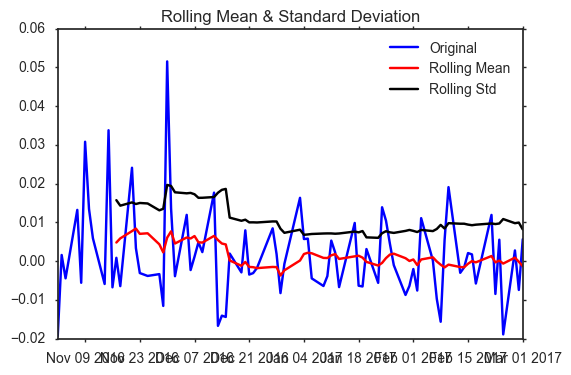

Results of Dickey-Fuller Test:


LinAlgError: SVD did not converge

In [48]:
test_stationarity(ts_eng)